In [65]:
import os
import random
import time
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
# !pip install moviepy
from moviepy import ImageSequenceClip
import torch
import torch.nn as nn

In [4]:
video_path = "/mnt/disks/behemoth/datasets/UDM10_video/000/"

## Load & Viz - Post U-Net Latents:

In [5]:
udm_000_zs = []
for latent_f in tqdm(sorted(os.listdir(video_path))):
    if latent_f.endswith(".pt"):
        latent_path = os.path.join(video_path, latent_f)
        latent = torch.load(latent_path, map_location="cpu") # torch.Size([1, 4, 64, 64]) cpu torch.bfloat16
        # print(latent_path, latent.size(), latent.device, latent.dtype)
        udm_000_zs.append(latent.squeeze(0))

100%|██████████| 64/64 [00:00<00:00, 1198.77it/s]


In [6]:
def viz_one_latent(z):
    z = z.permute(1,2,0).float().numpy()
    # print(z.shape)
    z_c1 = z[:, :, 0]
    z_c2 = z[:, :, 1]
    z_c3 = z[:, :, 2]
    z_c4 = z[:, :, 3]
    # print(z_c1.shape)

    fig, axs = plt.subplots(1, 4, figsize=(8, 8))
    
    axs[0].imshow(z_c1, cmap='gray')
    axs[0].axis("off")
    axs[0].set_title("z_c1")

    axs[1].imshow(z_c2, cmap='gray')
    axs[1].axis("off")
    axs[1].set_title("z_c2")

    axs[2].imshow(z_c3, cmap='gray')
    axs[2].axis("off")
    axs[2].set_title("z_c3")
    
    axs[3].imshow(z_c4, cmap='gray')
    axs[3].axis("off")
    axs[3].set_title("z_c4")

    plt.tight_layout()
    plt.show()

In [7]:
# ZC1 = []
# ZC2 = []
# ZC3 = []
# ZC4 = []
# for i in range(len(udm_000_zs)):
#     print(f"t = {i}")
#     viz_one_latent(udm_000_zs[i])
    # z = udm_000_zs[i].permute(1,2,0).float().numpy()
    # z_c1 = np.repeat(z[:, :, 0][:, :, np.newaxis], 3, axis=2)
    # z_c2 = np.repeat(z[:, :, 1][:, :, np.newaxis], 3, axis=2)
    # z_c3 = np.repeat(z[:, :, 2][:, :, np.newaxis], 3, axis=2)
    # z_c4 = np.repeat(z[:, :, 3][:, :, np.newaxis], 3, axis=2)
    # ZC1.append(z_c1)
    # ZC2.append(z_c2)
    # ZC3.append(z_c3)
    # ZC4.append(z_c4)

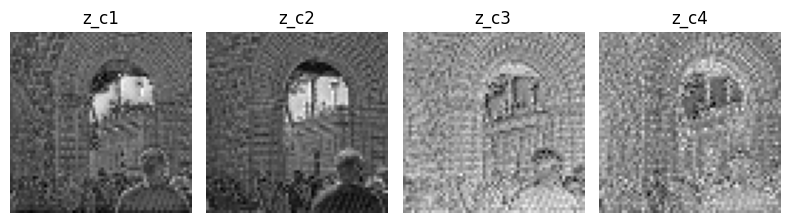

In [8]:
viz_one_latent(udm_000_zs[0])

(64, 64, 4) t = 0


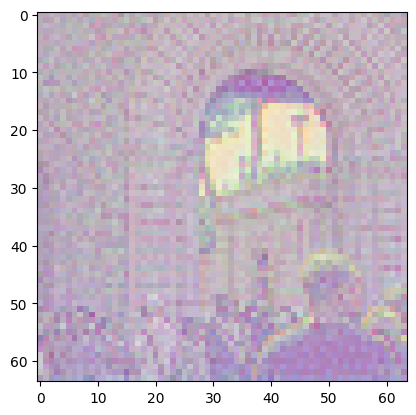

(64, 64, 4) t = 1


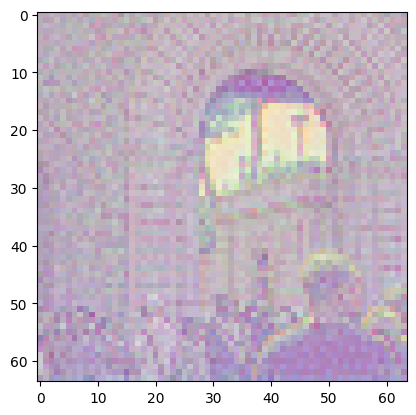

(64, 64, 4) t = 2


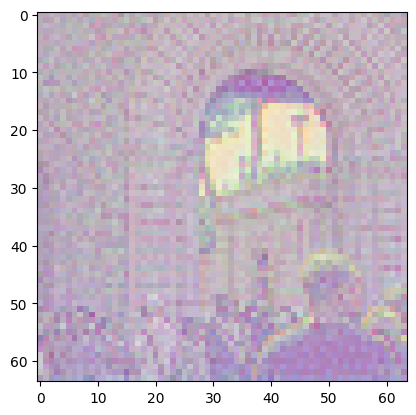

In [18]:
for i in range(len(udm_000_zs)):
    disp_worthy = udm_000_zs[0].permute(1,2,0).float().numpy()
    print(disp_worthy.shape, "t =",i)
    disp_worthy = (disp_worthy - np.amin(disp_worthy)) / (np.amax(disp_worthy) - np.amin(disp_worthy))
    plt.imshow(disp_worthy)
    plt.show()
    if i == 2:
        break

## Get the Decoder

```
vae.decode:
    z = self.post_quant_conv(z)
    dec = self.decoder(z)


x = self.vae.decode(z.to(self.weight_dtype) / 0.18215).float()
```

In [19]:
from gqvr.model.vae import AutoencoderKL
from omegaconf import OmegaConf

use sdp attention as default
keep default attention mode


/home/argar/miniconda3/envs/hypir/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [22]:
device = torch.device("cuda:7")

In [54]:
cfg = OmegaConf.load("/home/argar/apgi/gQVR/configs/train/train_sd2gan_video.yaml")
vae = AutoencoderKL(cfg.model.vae_cfg.ddconfig, 
                    cfg.model.vae_cfg.embed_dim)
# Load quanta VAE
daVAE = torch.load(cfg.qvae_path, map_location="cpu")
init_vae = {}
vae_used = set()
scratch_vae = vae.state_dict()
for key in scratch_vae:
    if key not in daVAE:
        print(f"[!] {key} missing in daVAE")
        continue
    # print(f"Found {key} in daVAE. Loading...")
    init_vae[key] = daVAE[key].clone()
    vae_used.add(key)
vae.load_state_dict(init_vae, strict=True)
# vae.to(device=device)
vae_unused = set(daVAE.keys()) - vae_used

if len(vae_unused) == 0:
    print(f"[+] Loaded qVAE successfully")
else:
    print(f"[!] VAE keys NOT used: {vae_unused}")

vae.requires_grad_(False)

post_quant_conv = vae.post_quant_conv.to(device)
decoder = vae.decoder.to(device)

building SDPAttnBlock (sdp) with 512 in_channels
building SDPAttnBlock (sdp) with 512 in_channels
[+] Loaded qVAE successfully


In [55]:
# print(post_quant_conv.weight.dtype)

In [56]:
def decode_latent(z):
    z = z.to(post_quant_conv.weight.dtype)
    z = post_quant_conv(z)
    dec = decoder(z)
    return dec.float()

In [57]:
z_clean_000 = udm_000_zs[0].to(device).to(torch.float32).unsqueeze(0)
print(z_clean_000.size(), z_clean_000.dtype, z_clean_000.device)

torch.Size([1, 4, 64, 64]) torch.float32 cuda:7


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.014322907..1.0404152].


torch.Size([1, 3, 512, 512])


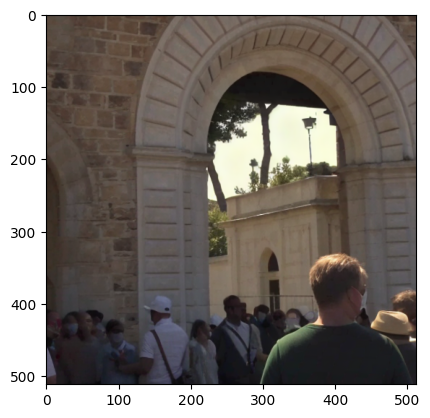

In [60]:
out = (decode_latent(z_clean_000) + 1) / 2
print(out.size())
plt.imshow(out.squeeze(0).permute(1,2,0).detach().cpu().numpy())
plt.show()

## Laplacian Smoothing

* Split latent into low + high frequency parts.

* Blend the high frequency residuals over time (so static details don’t shimmer).

* Recombine with low frequencies for the stabilized latent.

In [94]:
import torch.nn.functional as F
class LaplacianTemporalSmoothing(nn.Module):
    def __init__(self, kernel_size=5, sigma=1.0, alpha=0.7):
        """
        kernel_size : size of Gaussian kernel for low-pass
        sigma       : std of Gaussian blur
        alpha       : weight for current frame's high freq vs. previous
                      - alpha=1.0 → keep current HF only
                      - alpha=0.0 → copy previous HF
        """
        super().__init__()
        self.alpha = alpha
        self.kernel_size = kernel_size
        self.sigma = sigma
        
        # Precompute Gaussian kernel (2D applied to H,W dims, broadcast over channels & T)
        coords = torch.arange(kernel_size).float() - kernel_size // 2
        g = torch.exp(-(coords**2) / (2 * sigma**2))
        g = g / g.sum()
        gauss_1d = g.view(1, -1)
        gauss_2d = gauss_1d.t() @ gauss_1d
        self.register_buffer("gauss_kernel", gauss_2d)

    def gaussian_blur(self, x):
        """Apply separable Gaussian blur to spatial dims (H, W)."""
        C = x.shape[1]
        kernel = self.gauss_kernel[None, None, :, :]  # [1,1,k,k]
        kernel = kernel.repeat(C, 1, 1, 1)           # [C,1,k,k]

        padding = self.kernel_size // 2
        x = F.conv2d(x, kernel, padding=padding, groups=C)
        return x

    def forward(self, z_t, z_prev=None):
        """
        z_t:     [B, C, H, W] latent at time t
        z_prev:  [B, C, H, W] stabilized latent at time t-1 (or None for first frame)
        """
        # Low-pass filter
        low_t = self.gaussian_blur(z_t)
        high_t = z_t - low_t

        if z_prev is None:
            # First frame: no stabilization
            return z_t

        # Decompose prev stabilized latent
        low_prev = self.gaussian_blur(z_prev)
        high_prev = z_prev - low_prev

        # Blend high frequencies (static detail preservation)
        high_stab = self.alpha * high_t + (1 - self.alpha) * high_prev

        # Recombine stabilized latent
        z_stab = low_t + high_stab
        return z_stab

In [99]:
stabilizer = LaplacianTemporalSmoothing(alpha=0.3).to(device)
trainable_params_stabilizer = sum(p.numel() for p in stabilizer.parameters() if p.requires_grad)
print(trainable_params_stabilizer, "- Hence traditional ;)")

0 - Hence traditional ;)


In [100]:
z_prev = None
stabilized_zGs = []
for z_t in udm_000_zs:
    z_t = z_t.unsqueeze(0).to(device).to(torch.float32)
    z_stab = stabilizer(z_t, z_prev)
    stabilized_zGs.append(z_stab)
    z_prev = z_stab.detach()

In [101]:
decoded_laplacian_udm = []
for i in range(len(stabilized_zGs)):
    dec = decode_latent(stabilized_zGs[i])
    decoded_laplacian_udm.append( ( ((dec + 1) / 2)*255.0 ).clamp(0, 255).to(torch.uint8).squeeze(0).permute(1,2,0).contiguous().detach().cpu().numpy())


In [102]:
def save_frames(arr, out_path = "./experiments_video/"):
    for i, frame in enumerate(arr):
        z_str = str(i).zfill(3)
        plt.imsave(os.path.join(out_path, f"frame_{z_str}.png"), frame)

save_frames(decoded_laplacian_udm)